In [1]:
import pandas as pd
import os
import numpy as np

HOUSING_PATH = os.path.join("D:\HCMUE\ML\handson-ml2\datasets", "housing")

In [2]:
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [3]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
housing_labels = housing["median_house_value"].copy()

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(housing, housing_labels, test_size=0.2, random_state=0)

In [6]:
# drop make train dimension unfit with test 
# X_train = X_train.drop(["ocean_proximity", "total_bedrooms"], axis=1)

In [7]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 12069 to 2732
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16354 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
 8   median_house_value  16512 non-null  float64
 9   ocean_proximity     16512 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.4+ MB


In [8]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4128 entries, 14740 to 4148
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           4128 non-null   float64
 1   latitude            4128 non-null   float64
 2   housing_median_age  4128 non-null   float64
 3   total_rooms         4128 non-null   float64
 4   total_bedrooms      4079 non-null   float64
 5   population          4128 non-null   float64
 6   households          4128 non-null   float64
 7   median_income       4128 non-null   float64
 8   median_house_value  4128 non-null   float64
 9   ocean_proximity     4128 non-null   object 
dtypes: float64(9), object(1)
memory usage: 354.8+ KB


In [9]:
X_train_num = X_train.drop(['ocean_proximity'], axis=1)


In [10]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

num_pipeline = Pipeline([
('imputer', SimpleImputer(strategy="median")),
# ('attribs_adder', CombinedAttributesAdder()),
# ('std_scaler', StandardScaler()),
])

In [11]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

num_attribs = list(X_train_num)
cat_attribs = ["ocean_proximity"]
full_pipeline = ColumnTransformer([
("num", num_pipeline, num_attribs),
("cat", OneHotEncoder(), cat_attribs),
])
X_train_prepared = full_pipeline.fit_transform(X_train)
X_test_prepared = full_pipeline.fit_transform(X_test)

In [12]:
X_test

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
14740,-117.05,32.58,22.0,2101.0,399.0,1551.0,371.0,4.1518,136900.0,NEAR OCEAN
10101,-117.97,33.92,32.0,2620.0,398.0,1296.0,429.0,5.7796,241300.0,<1H OCEAN
20566,-121.84,38.65,29.0,3167.0,548.0,1554.0,534.0,4.3487,200700.0,INLAND
2670,-115.60,33.20,37.0,709.0,187.0,390.0,142.0,2.4511,72500.0,INLAND
15709,-122.43,37.79,25.0,1637.0,394.0,649.0,379.0,5.0049,460000.0,NEAR BAY
...,...,...,...,...,...,...,...,...,...,...
6655,-118.13,34.16,33.0,2682.0,716.0,2050.0,692.0,2.4817,169500.0,<1H OCEAN
3505,-118.45,34.25,36.0,1453.0,270.0,808.0,275.0,4.3839,204600.0,<1H OCEAN
1919,-120.92,38.86,11.0,1720.0,345.0,850.0,326.0,3.2027,128600.0,INLAND
1450,-121.95,37.96,18.0,2739.0,393.0,1072.0,374.0,6.1436,259500.0,INLAND


In [13]:
X_test_prepared[0]

array([-1.1705e+02,  3.2580e+01,  2.2000e+01,  2.1010e+03,  3.9900e+02,
        1.5510e+03,  3.7100e+02,  4.1518e+00,  1.3690e+05,  0.0000e+00,
        0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00])

In [35]:
# training
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X_train_prepared, y_train)

LinearRegression()

In [36]:
# evaluate
from sklearn.metrics import mean_squared_error
housing_predictions = lin_reg.predict(X_test_prepared)
lin_mse = mean_squared_error(y_test, housing_predictions)
lin_mse
# lin_rmse = np.sqrt(lin_mse)
# lin_rmse

3.895453200751032e-21

In [37]:
print("Predictions:", lin_reg.predict(X_test_prepared[:10]))
print("Labels:", list(y_test[:10]))

Predictions: [136900. 241300. 200700.  72500. 460000. 120000. 247000. 336900. 339700.
 265600.]
Labels: [136900.0, 241300.0, 200700.0, 72500.0, 460000.0, 120000.0, 247000.0, 336900.0, 339700.0, 265600.0]


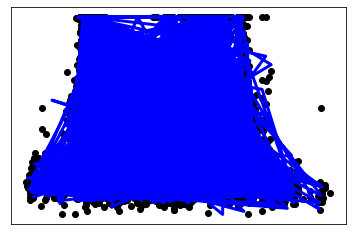

In [51]:
import matplotlib.pyplot as plt

plt.scatter(X_train_prepared[:,0], y_train,  color='black')
plt.plot(X_test_prepared[:,0], housing_predictions, color='blue', linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()